# Feature Reduction

### Todo

Maybe: Add an alternative to PCA

#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [1101]:
import os 
#Input the directory where your joined_data.csv is located 
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
# os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

#Where you want the csv file of the merged data to be placed
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/Trond/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 1000)




'''
Various flags for which preprocessing steps to take and what graphics we want to show:
'''

'''
    Flags for which missing value imputation to use
'''
    
# 0 = MODE/MEAN IMPUTATION, 1 = SIMILARITY MEASURE
MV_FLAG = 0  

'''
'''
    

'''
    Flags for outlier detection and removal
'''
# The ratio of outliers that we expect in our data and consquently will be classified as such by Isolation Forest
OUTLIER_RATIO = 0.1
    
# 0 = No, 1 = Yes
SHOW_OUTLIER_STATISTICS = 1

# 0 = No, 1 = Yes
SHOW_OUTLIER_OBSERVATIONS = 0

SHOW_EVENT_ID_TO_ANOMALY_RATIO = 1

# 0 = No, 1 = Yes
REMOVE_OUTLIERS = 0

'''
'''


'''
    Flags for graphical representations of distributions and pearson correlation heatmaps
'''

# 0 = No, 1 = Yes
SHOW_DISTRIBUTIONS = 0

# 0 = No, 1 = Yes
SHOW_HEATMAP = 0

'''
'''

'''
    Flags for how we split our data into training and test sets
'''

#The portion of data in the test set
TEST_PORTION = 0.3

'''
'''

'''
    Flags for how we standardize and one-hot encode our variables
'''

#Whether to leave one out in one-hot encoding, e.g dropping MALE in MALE/FEMALE because MALE can be infered from FEMALE = 0
# 0 = No, 1 = Yes
ONE_HOT_LEAVE_ONE_OUT = 0

#Whether we standarize ordinal variables or not
# 0 = No, 1 = Yes
STANDARDIZE_ORDINAL = 0

'''
    Flags for how we process our components variables
'''
# 0 = no derived total scores, 1 = derived total scores with no dichotomization, 2 = derived total scores with dichotomization
DERIVED_TOTAL_SCORES = 2
'''
'''

'''
    Flags for dimensionality reduction algorithms
'''

# 0 = no dimensionality reduction, 1 = PCA 
DIMENSIONALITY_REDUCTION = 0

if DIMENSIONALITY_REDUCTION == 1:
    #Set ratio of variance to keep for PCA dimensions, translates to the number of dimensions of PCA kept
    VARIANCE_KEEP = 0.9
    
'''
'''

'''
    Flags for how we deal with longitudinal data
'''
    
# 0 = Only Baseline data, 1 = i-approach, 2 = LSTM-Approach

LONGITUDINAL_APPROACH = 1

'''
degree [0,x], -1 if you don't want intercept
average, 0 = No, 1= Yes
max, 0 = No, 1= Yes
min, 0 = No, 1= Yes
'''
if LONGITUDINAL_APPROACH != 0:
    if LONGITUDINAL_APPROACH == 1:
        NUMERIC_APPROACH = {
            "degree": 1,
            "average": 1,
            "max" : 1,
            "min" : 1
        }
    if LONGITUDINAL_APPROACH == 2:
        
        #Whether or not to to normalize all features such that they are between [0,1]
        # 0 = No, 1 = Yes
        NORMALIZE_DATA = 0
'''
'''

'''
    Flags for sampling techniques
'''
# 0 = No over/undersampling, 1 = SMOTE
SAMPLING = 0


'''
'''

'''
    Flags for whether to save the results to a folder
'''
# 0 = No, 1 = Yes
SAVE_RESULTS = 1

if SAVE_RESULTS:
    FOLDER_NAME = "Derived_Approach"

    PARAMETERS = {
        "MV_FLAG" : MV_FLAG,
        "OUTLIER_RATIO" : OUTLIER_RATIO,
        "REMOVE_OUTLIERS" : REMOVE_OUTLIERS,
        "TEST_PORTION" : TEST_PORTION,
        "ONE_HOT_LEAVE_ONE_OUT" : ONE_HOT_LEAVE_ONE_OUT,
        "STANDARDIZE_ORDINAL" : STANDARDIZE_ORDINAL,
        "DERIVED_TOTAL_SCORES" : DERIVED_TOTAL_SCORES,
        "DIMENSIONALITY_REDUCTION" : DIMENSIONALITY_REDUCTION,
        "LONGITUDINAL_APPROACH" : LONGITUDINAL_APPROACH,
        "SAMPLING" : SAMPLING       
}
    
    if DIMENSIONALITY_REDUCTION == 1:
        PARAMETERS["VARIANCE_KEEP"] = VARIANCE_KEEP

    if LONGITUDINAL_APPROACH == 1:
        PARAMETERS["NUMERIC_APPROACH"] = NUMERIC_APPROACH

    if LONGITUDINAL_APPROACH == 2:
        PARAMETERS["NORMALIZE_DATA"] = NORMALIZE_DATA   
        
'''
'''

#Just to stop \n being printed out due to the open strings
clear = 1

#### In this cell we import our joined imputed data based on MV_FLAG. We also create a dataframe that connects PATNO with first psychosis EVENT_ID

In [1102]:
if MV_FLAG == 0:
    data = pd.read_csv('joined_data_mm.csv') # missing values filled with mean/median
else: 
    data = pd.read_csv('joined_data_heom.csv') # missing values filled based on HEOM measure

In [1103]:
from sklearn.ensemble import IsolationForest
tempdata = data.drop(["PATNO", "LAST_EVENT_ID", "EVENT_ID"], axis = 1)
fit = IsolationForest(random_state = 0, contamination = 'auto').fit(tempdata)

x = fit.decision_function(tempdata)




0.0566661251170693
0.03930613313759635
0.135278391392262
-0.0219461411581234


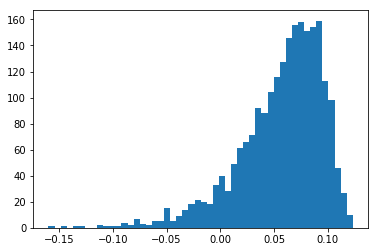

In [1104]:
import matplotlib.pyplot as plt

plt.hist(x, 50)

print(np.mean(x))
print(np.std(x))

print(np.mean(x) + (2 * np.std(x)))
print(np.mean(x) - (2 * np.std(x)))


#### In this cell we define a function for outlier detection and removal using Isolation Forest
#### We call this function with the flags set at start

In [1105]:
from sklearn.ensemble import IsolationForest

#ratio_to_remove is the important variable that determines the ratio of observations to remove as outliers
def outliers_IF (df, outlier_ratio, verbose, remove, show_outliers, event_id_to_anomaly_ratio ):
    tempdata = df.drop(["PATNO", "LAST_EVENT_ID", "EVENT_ID"], axis = 1)
    df["OUTLIERS_PRED"] = IsolationForest(random_state = 0, contamination = outlier_ratio, n_estimators = 100).fit_predict(tempdata)
    if verbose:
        print("Total datapoints: ", df.shape[0])
        print("Datapoints flagged as outliers: ", df.loc[df.OUTLIERS_PRED == -1, :].shape[0])
        print("Percentage of datapoints flagged as outliers: ", df.loc[df.OUTLIERS_PRED == -1, :].shape[0] / df.shape[0])

        print("\nDatapoints flagges as outliers who are of positive class: ", df.loc[(df.OUTLIERS_PRED == -1) & (df.NP1HALL != 0), :].shape[0])
        print("Percentage of positive class who are classified as outliers:", df.loc[(df.OUTLIERS_PRED == -1) & (df.NP1HALL != 0), :].shape[0] / df.loc[df.NP1HALL != 0, :].shape[0])

        print("\nDatapoints flagges as outliers who are of negative class: ", df.loc[(df.OUTLIERS_PRED == -1) & (df.NP1HALL == 0), :].shape[0])
        print("Percentage of negative class who are classified as outliers:", df.loc[(df.OUTLIERS_PRED == -1) & (df.NP1HALL == 0), :].shape[0] / df.loc[df.NP1HALL == 0, :].shape[0])
     
    if show_outliers:
        print("Observations which are classified as outliers with current outlier ratio of ", str(outlier_ratio))
        display(df.loc[df.OUTLIERS_PRED == -1, :])
        
    #Due to discoveries from looking at anomaly classified observations
    if event_id_to_anomaly_ratio:
        
        unique_event_id = df.EVENT_ID.unique()
        for u in unique_event_id:
            print("Ratio of observations with ", u, " as event_id classified as anomalies: ", df.loc[(df.EVENT_ID == u) & (df.OUTLIERS_PRED == -1), :].shape[0] / \
                  df.loc[df.EVENT_ID == u, :].shape[0])
        
        df.loc[df.EVENT_ID == u, :].shape[0] 
    
    if remove:
        df.drop(df[df.OUTLIERS_PRED == -1].index, inplace = True)
        
        
        
    df.drop("OUTLIERS_PRED", axis = 1, inplace = True)
    

outliers_IF (data,OUTLIER_RATIO, SHOW_OUTLIER_STATISTICS, REMOVE_OUTLIERS, SHOW_OUTLIER_OBSERVATIONS, SHOW_EVENT_ID_TO_ANOMALY_RATIO)


Total datapoints:  2250
Datapoints flagged as outliers:  225
Percentage of datapoints flagged as outliers:  0.1

Datapoints flagges as outliers who are of positive class:  46
Percentage of positive class who are classified as outliers: 0.27058823529411763

Datapoints flagges as outliers who are of negative class:  179
Percentage of negative class who are classified as outliers: 0.08605769230769231
Ratio of observations with  BL  as event_id classified as anomalies:  0.02403846153846154
Ratio of observations with  V04  as event_id classified as anomalies:  0.043731778425655975
Ratio of observations with  V06  as event_id classified as anomalies:  0.09259259259259259
Ratio of observations with  V12  as event_id classified as anomalies:  0.13380281690140844
Ratio of observations with  V08  as event_id classified as anomalies:  0.10443037974683544
Ratio of observations with  V10  as event_id classified as anomalies:  0.12457912457912458
Ratio of observations with  V13  as event_id classifi

#### In this cell we define a function that shows us interesting distributions for our response

In [1106]:
def show_dist (data):
    data_HALL_AFTER = data.copy(deep = True)
    unique_patno = data.PATNO.unique()
    event_ids = np.sort(data.EVENT_ID.unique())
    for x in unique_patno:
        subject_data = data_HALL_AFTER.loc[data_HALL_AFTER.PATNO == x, ["EVENT_ID", "HALL"]]
        subject_event_ids = np.sort(subject_data.EVENT_ID.unique())
        first_hall = 0
        for i in subject_event_ids:
            if first_hall != 1 and subject_data.loc[subject_data.EVENT_ID == i, ["HALL"]].values[0] == 1:
                    first_hall = 1
            elif first_hall == 1:
                    data_HALL_AFTER.loc[(data_HALL_AFTER.PATNO == x) & (data_HALL_AFTER.EVENT_ID == i), ["HALL"]] = 1

    event_id_to_years = {
        "BL" : "Baseline",
        "V04": "1-Year",
        "V06": "2-Year",
        "V08": "3-Year",
        "V10": "4-Year",
        "V12": "5-Year",
        "V13": "6-Year",
        "V14": "7-Year",
        "V15": "8-Year"   
    }

    '''
    distribution1 = Total subjects in the study per year
    distribution2 = Subjects with a non-missing datapoint per year
    distribution3 = Percentage of remaining subjects in the study with a non-missing datapoint per year
    distribution4 = Number of subjects with a non-missing datapoint that report hallucinations per year
    distribution5 = Number of subjects with a non-missing datapoint that report hallucinations or have reported hallucinations a previous years per year
    distribution6 = Percentage of subjects with a non-missing datapoint that report hallucinations per year
    distribution7 = Percentage of subjects with a non-missing datapoint that report hallucinations or have reported hallucinations previous years per year
    distribution8 = Number of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
    distribution9 = Percentage of previously non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
    '''

    #Total subjects in the study per year
    distribution1 = {}

    subjects = data.PATNO.unique().size
    for x in event_ids:
        distribution1 [event_id_to_years[x]] = subjects
        subjects -= data.loc[data.LAST_EVENT_ID == x, "PATNO"].unique().size


    #Subjects with a datapoint per year
    distribution2 = {}

    for x in event_ids:
        distribution2 [event_id_to_years[x]] = data.loc[data.EVENT_ID == x, "PATNO"].unique().size



    #Percentage of remaining subjects with a datapoint per year       
    distribution3 = {}
    subjects = data.PATNO.unique().size
    for x in event_ids:
        distribution3 [event_id_to_years[x]] = (data.loc[data.EVENT_ID == x, "PATNO"].unique().size / subjects) * 100
        subjects -= data.loc[data.LAST_EVENT_ID == x, "PATNO"].unique().size


    # Number of subjects with a datapoint that report hallucinations per year
    distribution4 = {}
    for x in event_ids:
        subjects_hall = data.loc[(data.EVENT_ID == x) & (data.HALL == 1), "PATNO"].values
        distribution4[event_id_to_years[x]] = subjects_hall.size 


    #Number of subjects with a datapoint that report hallucinations or have reported hallucinations priorly per year
    distribution5 = {}

    for x in event_ids:
        subjects_hall = data_HALL_AFTER.loc[(data_HALL_AFTER.EVENT_ID == x) & (data_HALL_AFTER.HALL == 1), "PATNO"].values
        distribution5[event_id_to_years[x]] = subjects_hall.size 


    #Percentage of subjects with a non-missing datapoint that report hallucinations per year
    distribution6 = {}

    for x in event_ids:
        subjects_hall = data.loc[(data.EVENT_ID == x) & (data.HALL == 1), "PATNO"].values
        distribution6[event_id_to_years[x]] = (subjects_hall.size / data.loc[data.EVENT_ID == x, "PATNO"].unique().size) * 100

    #Percentage of subjects with a non-missing datapoint that report hallucinations or have reported hallucinations previous years per year
    distribution7 = {}

    for x in event_ids:
        subjects_hall = data_HALL_AFTER.loc[(data_HALL_AFTER.EVENT_ID == x) & (data_HALL_AFTER.HALL == 1), "PATNO"].values
        distribution7[event_id_to_years[x]] = (subjects_hall.size / data.loc[data.EVENT_ID == x, "PATNO"].unique().size) * 100

    #Number of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
    distribution8 = {}

    tempdata = data_HALL_AFTER.copy(deep = True)
    for x in event_ids: 
        subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
        distribution8[event_id_to_years[x]] = subjects_hall.size

        for i in subjects_hall:
            tempdata = tempdata[tempdata.PATNO != i]

    #Percentage of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
    distribution9 = {}

    tempdata = data_HALL_AFTER.copy(deep = True)
    for x in event_ids: 
        subjects_hall = tempdata.loc[(tempdata.EVENT_ID == x) & (tempdata.HALL == 1), "PATNO"].values
        distribution9[event_id_to_years[x]] = (subjects_hall.size / data.loc[data.EVENT_ID == x, "PATNO"].unique().size) * 100

        for i in subjects_hall:
            tempdata = tempdata[tempdata.PATNO != i]






    fig, axs = plt.subplots(5, 2)
    fig.set_size_inches(25, 25)
    fig.tight_layout(pad=5.0)
    fig.delaxes(axs[4,1])


    # distribution1 = Total subjects in the study per year
    axs[0,0].bar(distribution1.keys(), distribution1.values(), width=.5, color='g')
    axs[0,0].title.set_text("Total subjects in the study per year")

    #distribution2 = Subjects with a non-missing datapoint per year
    axs[0,1].bar(distribution2.keys(), distribution2.values(), width=.5, color='r')
    axs[0,1].title.set_text("Subjects with a non-missing datapoint per year")

    #distribution3 = Percentage of remaining subjects in the study with a non-missing datapoint per year
    axs[1,0].bar(distribution3.keys(), distribution3.values(), width=.5, color='y')
    axs[1,0].title.set_text("Percentage of remaining subjects in the study with a non-missing datapoint per year")

    #distribution4 = Number of subjects with a non-missing datapoint that report hallucinations per year
    axs[1,1].set_ylim(0,70)
    axs[1,1].bar(distribution4.keys(), distribution4.values(), width=.5, color='k')
    axs[1,1].title.set_text("Number of subjects with a non-missing datapoint that report hallucinations per year")

    #distribution5 = Number of subjects with non-missing datapoint that report hallucinations \n or have reported hallucinations a previous year per year
    axs[2,0].set_ylim(0,70)
    axs[2,0].bar(distribution5.keys(), distribution5.values(), width=.5, color='c')
    axs[2,0].title.set_text("Number of subjects with non-missing datapoint that report hallucinations \n or have reported hallucinations a previous year per year")

    #distribution6 = Percentage of subjects with a non-missing datapoint that report hallucinations per year
    axs[2,1].set_ylim(0,50)
    axs[2,1].bar(distribution6.keys(), distribution6.values(), width=.5, color='m')
    axs[2,1].title.set_text("Percentage of subjects with a non-missing datapoint that report hallucinations per year")

    #distribution7 = Percentage of subjects with a non-missing datapoint that report hallucinations or have reported hallucinations a previous year per year
    axs[3,0].set_ylim(0,50)
    axs[3,0].bar(distribution7.keys(), distribution7.values(), width=.5, color= '#3933FF')
    axs[3,0].title.set_text("Percentage of subjects with a non-missing datapoint that report hallucinations \n or have reported hallucinations a previous year per year")

    #Number of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
    axs[3,1].set_ylim(0,30)
    axs[3,1].bar(distribution8.keys(), distribution8.values(), width=.5, color= '#EE910C')
    axs[3,1].title.set_text("Number of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year")

    #Percentage of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year
    axs[4,0].set_ylim(0,20)
    axs[4,0].bar(distribution9.keys(), distribution9.values(), width=.5, color= '#978A8A')
    axs[4,0].title.set_text("Percentage of previoussly non-hallucinating subjects with a non-missing datapoint that present as new hallucinations cases per year")


#### In this cell we dichtomize our response and look at various distributions if flag is set

In [1107]:
#Print the percentage of subjects who experience a specfic category of NP1HALL as their worst category
unique_subjects = data.PATNO.unique()

score_dict = {0 : 0,
             1: 0,
             2 : 0,
             3 : 0,
             4 : 0,
             5 : 0}

for u in unique_subjects:
    
    max_category = np.max(data.loc[data.PATNO == u, "NP1HALL"])
    score_dict[max_category] += 1
    
    

print("Percentage of subjects with max category, NP1HALL == 0: ", score_dict[0] / unique_subjects.size)
print("Percentage of subjects with max category, NP1HALL == 1: ", score_dict[1] / unique_subjects.size)
print("Percentage of subjects with max category, NP1HALL == 2: ", score_dict[2] / unique_subjects.size)
print("Percentage of subjects with max category, NP1HALL == 3: ", score_dict[3] / unique_subjects.size)
print("Percentage of subjects with max category, NP1HALL == 4: ", score_dict[4] / unique_subjects.size)
print("Percentage of subjects with max category, NP1HALL == 5: ", score_dict[5] / unique_subjects.size)

'''Dihotomize NP1HALL dependent variable'''

# if the patient has not suffered hallucinations, we consider it 0
# if the patient has suffered >= 1 times hallucinations, we consider it 1   
data['HALL'] = data['NP1HALL'].apply(lambda x: np.where(x >=1, 1, 0))

data.drop('NP1HALL', inplace = True, axis = 1)
 
if SHOW_DISTRIBUTIONS == 1:
    show_dist(data)

    

Percentage of subjects with max category, NP1HALL == 0:  0.7548076923076923
Percentage of subjects with max category, NP1HALL == 1:  0.1971153846153846
Percentage of subjects with max category, NP1HALL == 2:  0.03125
Percentage of subjects with max category, NP1HALL == 3:  0.014423076923076924
Percentage of subjects with max category, NP1HALL == 4:  0.002403846153846154
Percentage of subjects with max category, NP1HALL == 5:  0.0


#### In this cell we make a dataframe that connects PATNO in data with first psychosis event_id

In [1108]:
rows_list = []
unique_subjects = data.PATNO.unique()  
for u in unique_subjects:
    subject_data = data.loc[data.PATNO == u, :].sort_values("EVENT_ID").reset_index(drop = True)
    if subject_data.loc[subject_data.HALL == 1, :].index.shape[0] != 0:
        FP_EVENT_ID = subject_data.loc[subject_data.HALL == 1, "EVENT_ID"].values[0]
        row = {
            'PATNO' : u,
            'FP_EVENT_ID' : FP_EVENT_ID
        }
    else:
        row = {
            'PATNO' : u,
            'FP_EVENT_ID' : 'NO_PSYCHOSIS'
        }
    rows_list.append(row)
            

FP_DF = pd.DataFrame(rows_list)

                

#### In this cell we define the functions we need to calculate derived values from various variables

In [1109]:
#Functions for calculating derived values for various data tables

def lnsqtot(df):
    ''' 
    Letter number sequencing 
    sum variables
    '''
    component_vars = ["LNS1A", "LNS1B", "LNS1C", \
        "LNS2A", "LNS2B", "LNS2C", "LNS3A", "LNS3B", "LNS3C", "LNS4A", "LNS4B", "LNS4C", "LNS5A", "LNS5B", "LNS5C", "LNS6A", "LNS6B", "LNS6C", \
        "LNS7A", "LNS7B", "LNS7C"]
                      
    df["LNSTOT"] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)                     
    
    

def hvlttot (df):
    
    component_vars = ["HVLTRT1", "HVLTRT2", "HVLTRT3", "HVLTREC", "HVLTFPRL", "HVLTFPUN"]
    
    #Immediate/Total recall
    df["HVLT_TOTAL"] = df.loc[:,["HVLTRT1", "HVLTRT2", "HVLTRT3"]].sum(axis = 1)
    
    #Discrimination Recognition
    df["HVLT_DISCRIM"] = df.HVLTREC - (df.HVLTFPRL + df.HVLTFPUN)
    
    #Retention
    df["HVLT_RETENTION"] = df.HVLTRDLY / df.loc[:,["HVLTRT2", "HVLTRT3"]].max(axis = 1)
    
    df.drop(component_vars,inplace = True, axis = 1)
    
    
def mcatot (df):
    ''' 
    Montreal cognitive test
    sum variables and 1 point to score if education years <= 12 and score < 30
    '''
    
    component_vars = ["MCAALTTM", "MCACUBE", "MCACLCKC", "MCACLCKN", "MCACLCKH", "MCALION", "MCARHINO", "MCACAMEL", \
    "MCAFDS", "MCABDS", "MCAVIGIL", "MCASER7", "MCASNTNC", "MCAVF", "MCAABSTR", "MCAREC1", "MCAREC2", "MCAREC3", "MCAREC4", \
    "MCAREC5", "MCADATE", "MCAMONTH", "MCAYR", "MCADAY", "MCAPLACE", "MCACITY"]
    
    df['MCATOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)
    
    df['MCATOT'] = df.apply(lambda row_wise: row_wise["MCATOT"] + 1 if row_wise["EDUCYRS"] <= 12 and row_wise["MCATOT"] < 30 else row_wise["MCATOT"] , axis=1)   
    

def vlttot (df):
    ''' Semantic Fluency
    VLTANIM, VLTVEG,VLTFRUIT need to be summed in order to obtain a final score'''
    
    component_vars = ["VLTANIM", "VLTVEG", "VLTFRUIT"]
    
    df['VLTTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def remqtot (df):
    '''REM sleep behavior disorder (RBD)'''
    
    component_vars = ["STROKE","HETRA", "PARKISM", "RLS", "NARCLPSY", "DEPRS", "EPILEPSY", "BRNINFM", "CNSOTH"]
        
    score = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    
    # 1 point if any of these component variables had a 1, else 0
    score = pd.Series(np.where(score >= 1, 1, 0))
    
    df.drop(component_vars, inplace = True, axis = 1)

    component_vars = ["DRMVIVID", "DRMAGRAC", "DRMNOCTB", "SLPLMBMV", "SLPINJUR", \
                      "DRMVERBL", "DRMFIGHT", "DRMUMV", "DRMOBJFL", "MVAWAKEN", "DRMREMEM", "SLPDSTRB"]
    
    score += df.loc[:, component_vars].sum(axis = 1, skipna = False)

    df['REMTOT'] = score
    df.drop(component_vars, inplace = True, axis = 1)

    
def gdsstot (df):
    '''Geriatric Depression Scale'''
    
    component_vars = ["GDSSATIS", "GDSDROPD", \
    "GDSEMPTY", "GDSBORED", "GDSGSPIR", "GDSAFRAD", "GDSHAPPY", "GDSHLPLS", "GDSHOME", "GDSMEMRY", "GDSALIVE", "GDSWRTLS", "GDSENRGY", \
    "GDSHOPLS", "GDSBETER"]
    
    df['GDSSTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def sidttot (df):
    '''Olfactory impairment: University of Pennsylvania Smell ID Test'''
    component_vars = ["UPSITBK1", "UPSITBK2", "UPSITBK3", "UPSITBK4"]
    
    df['SIDTTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def epsstot (df):
    '''Epworth Sleepiness Scale'''
    
    component_vars = ["ESS1", "ESS2", \
    "ESS3", "ESS4", "ESS5", "ESS6", "ESS7", "ESS8"]
    
    df['EPSSTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

    
def scoptot(df):
    '''Scales for Outcomes in Parkinson’s Disease–Autonomic'''

    component_vars = ["SCAU1", "SCAU2", \
    "SCAU3", "SCAU4", "SCAU5", "SCAU6", "SCAU7", "SCAU8", "SCAU9", "SCAU10", "SCAU11", "SCAU12", "SCAU13", \
    "SCAU14", "SCAU15", "SCAU16", "SCAU17", "SCAU18", "SCAU19", "SCAU20", "SCAU21", "SCAU22", "SCAU23", "SCAU24", "SCAU25"]
    
    df['SCOPTOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)
    

def msu3tot(df):
    '''Movement Disorders Society–Unified Parkinson Disease Rating Scale'''
    
    component_vars = ['NP3BRADY', 'NP3FACXP', 'NP3FRZGT', \
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML', 'NP3KTRMR', 'NP3LGAGL', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR', \
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'PN3RIGRL', 'NP3RIGN', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU', \
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR', 'NP3LGAGR', 'NP3RIGLU']
       
    df['MSU3TOT'] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    #df.drop(component_vars, inplace = True, axis = 1) #cannot drop, variables needed in tremor and pigd

    
def tremor(df):
    '''Tremor score'''
    
    component_vars = ["NP2TRMR", "NP3PTRMR", "NP3PTRML", "NP3KTRMR", "NP3KTRML", "NP3RTARU", "NP3RTALU", "NP3RTARL", "NP3RTALL", \
    "NP3RTALJ", "NP3RTCON"]
    
    df['TREMOR'] = df.loc[:, component_vars].mean(axis = 1, skipna = False)
    #df.drop(component_vars, inplace = True, axis = 1) #cannot drop, variables needed in tremor and pigd
    
    
def pigd(df):
    '''PIGD score'''
    
    component_vars = ["NP2WALK", "NP2FREZ", "NP3GAIT", "NP3FRZGT", "NP3PSTBL"]
    df['PIGD'] = df.loc[:, component_vars].mean(axis = 1, skipna = False)
    
    component_vars = ['NP3BRADY', 'NP3FACXP', 'NP3FRZGT', \
    'NP3FTAPL', 'NP3FTAPR', 'NP3GAIT', 'NP3HMOVL', 'NP3HMOVR', 'NP3KTRML', 'NP3KTRMR', 'NP3LGAGL', 'NP3POSTR', 'NP3PRSPL', 'NP3PRSPR', \
    'NP3PSTBL', 'NP3PTRML', 'NP3PTRMR', 'NP3RIGLL', 'PN3RIGRL', 'NP3RIGN', 'NP3RIGRU', 'NP3RISNG', 'NP3RTALJ', 'NP3RTALL', 'NP3RTALU', \
    'NP3RTARL', 'NP3RTARU', 'NP3RTCON', 'NP3SPCH', 'NP3TTAPL', 'NP3TTAPR', "NP2TRMR", "NP2WALK", "NP2FREZ", 'NP3LGAGR', 'NP3RIGLU']
    #cannot drop before we discuss missing values
    df.drop(component_vars, inplace = True, axis = 1) #drop everything from msu3tot, tremor and pig
    
def famtot (df):
    ''' Raw sum of PD family history'''
    component_vars = ["BIOMOMPD", "BIODADPD", "FULSIBPD", "HAFSIBPD", "MAGPARPD", "PAGPARPD", "MATAUPD", "PATAUPD", "KIDSPD"]   
    df["FAMTOT"] = df.loc[:, component_vars].sum(axis = 1, skipna = False)
    df.drop(component_vars, inplace = True, axis = 1)

#### In this cell we define functions for encoding and dichotomizing variables

In [1110]:
#Functions for encoding and dichotomizing variables

def ratio(x, y):
    ''' Calculate TD/PGID ratio'''
    
    if y == 0:
        if x == 0:
            ratio = 0 #indeterminate
        else: 
            ratio =1 #TD
    elif x/y >= 1.15:
        ratio = 1 #TD
    elif x/y <= 0.9:
        ratio = 2 #PIGD
    else:
        ratio = 0 #indeterminate 
    return ratio

def td_pigd_classification(df):
    '''Tremor/PIGD ratio'''
    
    component_vars = ['TREMOR', 'PIGD']
    df['TD_PIGD_RATIO'] = df.apply(lambda x: ratio(x['TREMOR'], x['PIGD']), axis=1)
    df.drop(component_vars, inplace = True, axis = 1)
   

def famhist(df):
    '''Family history of Parkinson's Disease'''
    
        
    score = df.FAMTOT
    
    # if score >= 1 then 1, else 0
    # if score = NaN, then 0
    score = pd.Series(np.where(score >= 1, 1, 0))
    
    df.drop(["FAMTOT"], inplace = True, axis = 1)
    df['FAMHIST'] = score
    
    
def sleepy(df):
    '''Dichotomize EPSSTOT, Epworth Sleepiness Scale'''
    
    # if score < 10 subjects will be classified as 0 (not sleepy)
    # if score >= 10 subject will be classified as 1 (sleepy).
    df['SLEEPY'] = df['EPSSTOT'].apply(lambda x: np.where(x >=10, 1, 0))

    df.drop('EPSSTOT', inplace = True, axis = 1)


def depr(df):
    '''Dichotomize GDSSTOT, Geriatric Depression Scale'''
    
    # if score <5 subjects will be classified as 0 (non-depressed).
    # if score >= 5 subjects will be classified as 1 (depressed) 
    df['DEPR'] = df['GDSSTOT'].apply(lambda x: np.where(x >=5, 1, 0))

    df.drop('GDSSTOT', inplace = True, axis = 1)


def rbd(df):
    '''Dichotomize REMTOT, REM sleep behavior disorder (RBD)'''
       
    # if score <5 subjects will be classified as 0 (RBD negative).
    # if score >= 5 subjects will be classified as 1 (RBD positive) 
    df['RBD'] = df['REMTOT'].apply(lambda x: np.where(x >=5, 1, 0))

    df.drop('REMTOT', inplace = True, axis = 1)

#### Derived_values and dichotomization wrapper function

In [1111]:
def derived_values(df, dichotomize):
    '''All derived_values preprocessing together'''
    lnsqtot(df)
    hvlttot(df)
    mcatot(df)
    vlttot(df)
    remqtot(df)
    gdsstot(df)
    sidttot(df)
    epsstot(df)
    scoptot(df)
    msu3tot(df)
    tremor(df)
    pigd(df)
    famtot(df)
    
    if dichotomize == True:
        famhist(df)
        sleepy(df)
        depr(df)
        rbd(df)  
        td_pigd_classification(df)

#### In this cell we define our function for standardizing numerical and ordinal variables and one-hot encoding categorical ones

In [1112]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

def PD_MED_USE_ONEHOT (PD_SERIES, leave_one_out):
    
    df = pd.DataFrame()
    df["PD_MED_USE"] = PD_SERIES
    if not leave_one_out:
        df["C_MED_NO"] = 0
    df["C_MED_LEV"] = 0
    df["C_MED_AG"] = 0
    df["C_MED_OTHER"] = 0
    
    for index, row in df.iterrows():
        value = row["PD_MED_USE"]
        if value == 0 and not leave_one_out:
            df.at[index,"C_MED_NO"] = 1
        if value == 1:
            df.at[index,"C_MED_LEV"] = 1
        elif value == 2:
            df.at[index,"C_MED_AG"] = 1
        elif value == 3:
            df.at[index,"C_MED_OTHER"] = 1
        elif value == 4: 
            df.at[index,"C_MED_LEV"] = 1
            df.at[index,"C_MED_OTHER"] = 1
        elif value == 5:
            df.at[index,"C_MED_LEV"] = 1
            df.at[index,"C_MED_AG"] = 1    
        elif value == 6:
            df.at[index,"C_MED_AG"] = 1
            df.at[index,"C_MED_OTHER"] = 1  
        elif value == 7:
            df.at[index,"C_MED_LEV"] = 1
            df.at[index,"C_MED_AG"] = 1   
            df.at[index,"C_MED_OTHER"] = 1 
    df.drop("PD_MED_USE", inplace = True, axis = 1)
    return df

    
def standardize (numeric_train, numeric_test):
    
    scaler = StandardScaler()
    scaler.fit(numeric_train)
    
    numeric_train[numeric_train.columns] = scaler.transform(numeric_train[numeric_train.columns])
    numeric_test[numeric_test.columns] = scaler.transform(numeric_test[numeric_test.columns])
    
    
    return numeric_train,numeric_test

            
def one_hot_encode(categorical_train, categorical_test, column_types, leave_one_out):
    
    columns = categorical_train.columns
    temptrain = pd.DataFrame()
    temptest = pd.DataFrame()
    for x in columns:
        column_info = column_types.loc[column_types.COLUMN_NAME == x,:]
        if column_info["0"].values[0] == "NO_USE":
            temptrain[x] = categorical_train[x]
            temptest[x] = categorical_test[x]
        elif column_info["0"].values[0] == "USE_SPECIAL_FUNCTION":
            code_string = x + "_ONEHOT"
            data_return_train = globals()[code_string](categorical_train[x], leave_one_out)
            data_return_test = globals()[code_string](categorical_test[x], leave_one_out)
            for x in data_return_train.columns:
                temptrain[x] = data_return_train[x]
                temptest[x] = data_return_test[x]
        else:
            categorical_predictor_train = np.array(train[x]).reshape(-1,1)
            categorical_predictor_test = np.array(test[x]).reshape(-1,1)            
            if leave_one_out:
                enc = OneHotEncoder(sparse = False, drop = "first")
            else:
                enc = OneHotEncoder(sparse = False)
            enc.fit(categorical_predictor_train)
            
            categorical_predictor_train = enc.transform(categorical_predictor_train)
            categorical_predictor_test = enc.transform(categorical_predictor_test)
            
            for i in range(0,categorical_predictor_train.shape[1]):
                column_name = "C_" + column_types.loc[column_types.COLUMN_NAME == x, str(i)].values[0]
                temptrain[column_name] = categorical_predictor_train[:,i]
                temptest[column_name] = categorical_predictor_test[:,i]
                
    return temptrain,temptest

def standardize_and_encode (train, test, data_types_filename, categorical_leave_one_out, ordinal_as_numeric):
    
    response_train = train.pop("HALL")
    response_test = test.pop("HALL")
    
    column_types = pd.read_csv(data_types_filename)
    numeric_columns = column_types.loc[column_types.DATA_TYPE != "Categorical", "COLUMN_NAME"].values 
    numeric_columns = np.intersect1d(numeric_columns, train.columns.values)   
    
    numeric_train = train.loc[:, numeric_columns]
    numeric_test = test.loc[:, numeric_columns]
    
    categorical_train = train.drop(numeric_columns, axis = 1)
    categorical_test = test.drop(numeric_columns, axis = 1)   
    
    
    if not ordinal_as_numeric:
        ordinal_columns = column_types.loc[column_types.DATA_TYPE == "Ordinal", "COLUMN_NAME"].values 
        ordinal_columns = np.intersect1d(ordinal_columns, numeric_train.columns.values)   
        
        ordinal_train = numeric_train.loc[:, ordinal_columns]
        ordinal_test = numeric_test.loc[:, ordinal_columns]
        
        numeric_train = numeric_train.drop(ordinal_columns, axis = 1)
        numeric_test = numeric_test.drop(ordinal_columns, axis = 1)
    
    numeric_train,numeric_test = standardize(numeric_train,numeric_test)
    categorical_train,categorical_test = one_hot_encode(categorical_train, categorical_test, column_types, categorical_leave_one_out)
    
    train = pd.concat([numeric_train, categorical_train], axis = 1)
    train = pd.concat([train,response_train], axis = 1)
    
    test = pd.concat([numeric_test, categorical_test], axis = 1)  
    test = pd.concat([test,response_test], axis = 1)
    
    if not ordinal_as_numeric:
        train = pd.concat([train, ordinal_train], axis = 1)
        test = pd.concat([test, ordinal_test], axis = 1)
    
    return train,test

#### In this cell we define our functions for dimensionality reduction

In [1113]:
from sklearn.decomposition import PCA

def dimreduc_PCA (train, test, variance_keep):
    non_predictor_variables = ["HALL", "EVENT_ID", "LAST_EVENT_ID", "PATNO"]
    temptrain = train.loc[:, non_predictor_variables]
    temptest = test.loc[:, non_predictor_variables]
    train.drop(non_predictor_variables, axis = 1, inplace = True)
    test.drop(non_predictor_variables, axis = 1, inplace = True)
    
    pca = PCA(svd_solver = "full")
    pca.fit(train)
    
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    if variance_keep == 1:
        index = np.where(cumsum > 0)[0][-1]
    else:    
        index = np.where(cumsum >= variance_keep)[0][0]
    
    train_transform = pca.transform(train)
    test_transform = pca.transform(test)
    
    for i in range(0,index + 1):
        temptrain["PCA" + str(i)] = train_transform[:,i]
        temptest["PCA" + str(i)] = test_transform[:,i]
        
    return temptrain,temptest
    
    

#### In this cell we define our functions for longitudinal approaches

In [1114]:
from numpy.polynomial import polynomial as np_P
import math

def i_approach (df, numeric_approach):
    
    new_df = pd.DataFrame()
    
    non_longitudinal_columns = []
    for c in df.columns:
        #Check to see if the variable has longitudinal data, if it doesn't, don't take statistics for this variable
        NOT_LONGITUDINAL = 1
        for subject in df.PATNO.unique():
            if df.loc[df.PATNO == subject, c].unique().size > 1:
                NOT_LONGITUDINAL = 0
                break      
        if NOT_LONGITUDINAL:
            non_longitudinal_columns.append(c)
            
    event_id_to_years = {
        "BL" : 0,
        "V04" : 1,
        "V06" : 2,
        "V08" : 3,
        "V10" : 4,
        "V12" : 5,
        "V13" : 6,
        "V14" : 7,
        "V15" : 8
    }
    
    unique_subjects = df.PATNO.unique()  
    for x in unique_subjects:
        #We find i and drop observations after i if applicable
        subject_data = df.loc[df.PATNO == x, :].sort_values("EVENT_ID").reset_index(drop = True)
        #We only drop data if i != LAST_EVENT_ID
        if subject_data.loc[subject_data.HALL == 1, :].index.shape[0] != 0:
            i = subject_data.loc[subject_data.HALL == 1, :].index[0]
            if i != subject_data.index[-1]:
                subject_data.drop(subject_data.index[i +1:], axis = 0, inplace = True)
         
        if subject_data.shape[0] >= 3:
            new_row = {}
            
            years_after_BL = subject_data.apply(lambda row_wise: event_id_to_years [row_wise["EVENT_ID"]], axis = 1)
            years_after_BL = np.array(years_after_BL[0:-1])
            
            
            
            for c in subject_data.columns:
                if c == "PATNO":
                    new_row[c] = subject_data.PATNO.values[0]
                elif c == "EVENT_ID" or c == "LAST_EVENT_ID":
                    pass
                elif c == "HALL":
                    new_row[c] = subject_data.HALL.values[-1]
                elif c in non_longitudinal_columns:
                    new_row[c] = subject_data[c].values[0]
                elif "C_" in c:
                    new_row[c + "_MODE"] = subject_data[c][0:-1].mode()[0]

                else:
                    if numeric_approach["degree"] != -1:
                        X = years_after_BL
                        Y = np.array(subject_data[c][0:-1])   
                        degree = numeric_approach["degree"]
                        coefs = np_P.Polynomial.fit(X,Y,degree).convert().coef

                        for i in range(0,degree +1):
                            if coefs.size <= i:
                                new_row[c + "_DEGREE" + str(i)] = 0
                            else:
                                if i == 0:
                                    new_row[c + "_INTERCEPT"] = coefs[i]
                                else:
                                    new_row[c + "_DEGREE" + str(i)] = coefs[i]

                    if numeric_approach["average"] == 1:
                        new_row[c + "_MEAN"] = subject_data[c][0:-1].mean()

                    if numeric_approach["max"] == 1:
                        new_row[c + "_MAX"] = subject_data[c][0:-1].max()  

                    if numeric_approach["min"] == 1:
                        new_row[c + "_MIN"] = subject_data[c][0:-1].min()  

            new_df = new_df.append(new_row, ignore_index = True)
    
    #Removing columns where all values are the same, e.g AGE or PD_DURATION slope
    for c in new_df.columns:
        ALL_VALUES_SIMILAR = 1
        v0 = new_df[c].unique()[0]
        for v in new_df[c].unique():
            if not math.isclose(v0, v, abs_tol=0.00001):
                ALL_VALUES_SIMILAR = 0
        if ALL_VALUES_SIMILAR:
            new_df.drop([c],axis = 1, inplace = True)
    
    return  new_df



def bl_approach (df):
        

    HALL_EVER = []
    for id in df.PATNO.unique():        
        #Drop subjects with only baseline observations
        if df.loc[df.PATNO == id, "EVENT_ID"].size < 2:
            df = df[df.PATNO != id]      
        elif df.loc[(df.PATNO == id) & (df.HALL == 1), "HALL"].empty:
            HALL_EVER.append(0)
        else:
            HALL_EVER.append(1)

    df.drop("HALL", axis = 1, inplace = True)
    tempdf = pd.DataFrame(df.PATNO.unique(), columns = ["PATNO"])
    tempdf["HALL"] = HALL_EVER
    df = df.merge(tempdf, how = "inner", on = "PATNO") 
    
    #Selecting only Baseline observations
    df = df.loc[df.EVENT_ID == "BL", :]
    #We can then safely drop EVENT_ID and PATNO
    df.drop(["EVENT_ID", "LAST_EVENT_ID"], axis = 1, inplace = True)
    return df


def shift_approach (df):
    
    new_df = pd.DataFrame()
    
    unique_subjects = df.PATNO.unique()  
    
    for x in unique_subjects:
        
        #We find i and drop observations after i if applicable
        subject_data = df.loc[df.PATNO == x, :].sort_values("EVENT_ID").reset_index(drop = True)
        #We only drop data if i != LAST_EVENT_ID
        if subject_data.loc[subject_data.HALL == 1, :].index.shape[0] != 0:
            i = subject_data.loc[subject_data.HALL == 1, :].index[0]
            if i != subject_data.index[-1]:
                subject_data.drop(subject_data.index[i +1:], axis = 0, inplace = True)
        
        if subject_data.shape[0] == 1:
            pass
        else:
            subject_data.loc[:,"HALL"] = subject_data.loc[:, "HALL"].shift(-1)
            subject_data.drop(subject_data.tail(1).index,inplace=True)
            new_df = new_df.append(subject_data)
            
    new_df.drop(["EVENT_ID", "LAST_EVENT_ID"], axis = 1, inplace = True) 
    
    return new_df
    

#### In this cell we define a function that prints our a correlation heatmap of our features

In [1115]:
def corr_heatmap (df):
    #Using Pearson Correlation
    non_relevant_features = ["PATNO"]
    data = df.drop(non_relevant_features, axis = 1)
    plt.figure(figsize=(12,10))
    cor = data.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    plt.show()

#### In this cell we define our train test split function

In [1116]:
'''
We split into training and test so that we base standardization or dimensionality reduction mapping on training set only
We have to ensure that all longitudinal observations from one patient ends up in the same sample, we therefore split on PATNOs
We stratify our sampling by converting our response to HALL_EVER. 
This ensures an equal distribution of subjects who never experience hallucinations and those who do in both training and test
Both longitudinal and non-longitudinal models predict on HALL_EVER, although in slightly different forms 
'''
def split_data (data):
    tempdata = pd.DataFrame(data.PATNO.unique(), columns = ["PATNO"])

    HALL_EVER = []
    for id in data.PATNO.unique():

        if data.loc[(data.PATNO == id) & (data.HALL == 1), "HALL"].empty:
            HALL_EVER.append(0)
        else:
            HALL_EVER.append(1)

    Y = HALL_EVER
    X = tempdata

    train, test, _, _ = train_test_split( X, Y, test_size= TEST_PORTION, random_state= 36, stratify= Y, shuffle = True)

    train = data.merge(train, how = "inner", on = "PATNO")
    test = data.merge(test, how = "inner", on = "PATNO")
    
    return train,test

#### In this cell we do the final preprocessing as dictated by the flags set

In [1117]:
#We split our data into training and test sets
train,test = split_data(data)

#Checking class distribution for train,test to make sure it is stratified
unique_subjects_train = train.PATNO.unique()
score_dict_train = {0 : 0,
             1: 0
             }

unique_subjects_test = test.PATNO.unique()
score_dict_test = {0 : 0,
             1: 0
             }

for u in unique_subjects_train:
    
    max_category = np.max(train.loc[train.PATNO == u, "HALL"])
    score_dict_train[max_category] += 1
    
for u in unique_subjects_test:
    
    max_category = np.max(test.loc[test.PATNO == u, "HALL"])
    score_dict_test[max_category] += 1    
    
print("Total subjects train: ", unique_subjects_train.size)
print("Class counts train: ", score_dict_train[0] , " ", score_dict_train[1])

print("Total subjects test: ", unique_subjects_test.size)
print("Class counts test: ", score_dict_test[0] , " ", score_dict_test[1])



#Derived Scores option:
if DERIVED_TOTAL_SCORES != 0:
    if DERIVED_TOTAL_SCORES == 1: 
        derived_values(train, False)
        derived_values(test, False) 
    elif DERIVED_TOTAL_SCORES == 2:
        derived_values(train, True)
        derived_values(test, True) 
        print("Number of features after Derived scores and classification: ", train.shape[1])
    train,test = standardize_and_encode(train,test,"Column_Data_Types_Final.csv", ONE_HOT_LEAVE_ONE_OUT, STANDARDIZE_ORDINAL)  
else:
    
    train,test = standardize_and_encode(train,test,"Column_Data_Types.csv", ONE_HOT_LEAVE_ONE_OUT, STANDARDIZE_ORDINAL)   
    
#Dimensionality reduction option:
if DIMENSIONALITY_REDUCTION != 0:
    if DIMENSIONALITY_REDUCTION == 1:
        train,test = dimreduc_PCA(train,test, VARIANCE_KEEP)
        

#Longitudinal Statistics
if LONGITUDINAL_APPROACH == 0:
    train = bl_approach(train)
    test = bl_approach(test)
elif LONGITUDINAL_APPROACH == 1:
        train = i_approach(train,NUMERIC_APPROACH)
        test = i_approach(test,NUMERIC_APPROACH)
              
elif LONGITUDINAL_APPROACH == 2: 
    train = shift_approach(train)
    test = shift_approach(test)
    
    if NORMALIZE_DATA:
        from sklearn.preprocessing import MinMaxScaler
        train.loc[:, train.columns != "PATNO"] = MinMaxScaler().fit_transform(train.loc[:, train.columns != "PATNO"])
        test.loc[:,test.columns != "PATNO"] = MinMaxScaler().fit_transform(test.loc[:, test.columns != "PATNO"])    

    
if SHOW_HEATMAP:
    corr_heatmap(train)

if SAMPLING != 0:
    if SAMPLING == 1:
        train["SAMPLING"] = "SMOTE"
else:
    train["SAMPLING"] = "NONE"
    
train.to_csv(output_filepath + '/train.csv', index = False)

Total subjects train:  291
Class counts train:  220   71
Total subjects test:  125
Class counts test:  94   31
Number of features after Derived scores and classification:  28


#### In this cell we can inspect the finished data

In [1118]:
train.head(10)

,AGE_INTERCEPT,AGE_MAX,AGE_MEAN,AGE_MIN,C_DEPR_NO_MODE,C_DEPR_YES_MODE,C_FAMHIST_NO,C_FAMHIST_YES,C_FEMALE,C_MALE,C_MED_AG_MODE,C_MED_LEV_MODE,C_MED_NO_MODE,C_MED_OTHER_MODE,C_PIGD_MODE,C_RBD_NO_MODE,C_RBD_YES_MODE,C_SLEEPY_NO_MODE,C_SLEEPY_YES_MODE,C_TD/PIGD_INDETERMINATE_MODE,C_TD_MODE,EDUCYRS,HALL,HVLTRDLY_DEGREE1,HVLTRDLY_INTERCEPT,HVLTRDLY_MAX,HVLTRDLY_MEAN,HVLTRDLY_MIN,HVLT_DISCRIM_DEGREE1,HVLT_DISCRIM_INTERCEPT,HVLT_DISCRIM_MAX,HVLT_DISCRIM_MEAN,HVLT_DISCRIM_MIN,HVLT_RETENTION_DEGREE1,HVLT_RETENTION_INTERCEPT,HVLT_RETENTION_MAX,HVLT_RETENTION_MEAN,HVLT_RETENTION_MIN,HVLT_TOTAL_DEGREE1,HVLT_TOTAL_INTERCEPT,HVLT_TOTAL_MAX,HVLT_TOTAL_MEAN,HVLT_TOTAL_MIN,JLO_TOTRAW_DEGREE1,JLO_TOTRAW_INTERCEPT,JLO_TOTRAW_MAX,JLO_TOTRAW_MEAN,JLO_TOTRAW_MIN,LNSTOT_DEGREE1,LNSTOT_INTERCEPT,LNSTOT_MAX,LNSTOT_MEAN,LNSTOT_MIN,MCATOT_DEGREE1,MCATOT_INTERCEPT,MCATOT_MAX,MCATOT_MEAN,MCATOT_MIN,MSU3TOT_DEGREE1,MSU3TOT_INTERCEPT,MSU3TOT_MAX,MSU3TOT_MEAN,MSU3TOT_MIN,NHY_DEGREE1,NHY_INTERCEPT,NHY_MAX,NHY_MEAN,NHY_MIN,NP1COG_DEGREE1,NP1COG_INTERCEPT,NP1COG_MAX,NP1COG_MEAN,NP1COG_MIN,PATNO,PD_DURATION_INTERCEPT,PD_DURATION_MAX,PD_DURATION_MEAN,PD_DURATION_MIN,SCOPTOT_DEGREE1,SCOPTOT_INTERCEPT,SCOPTOT_MAX,SCOPTOT_MEAN,SCOPTOT_MIN,SDMTOTAL_DEGREE1,SDMTOTAL_INTERCEPT,SDMTOTAL_MAX,SDMTOTAL_MEAN,SDMTOTAL_MIN,SIDTTOT,VLTTOT_DEGREE1,VLTTOT_INTERCEPT,VLTTOT_MAX,VLTTOT_MEAN,VLTTOT_MIN,SAMPLING
0,-2.586232,-1.972109,-2.279170,-2.586232,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.855287,1.0,-0.049033,0.780556,0.927654,0.633457,-0.102035,-3.147186e-17,0.737043,0.797071,0.737043,0.376875,-0.043825,0.772805,1.040626,0.641329,0.290726,-0.006428,0.522827,1.223505,0.503542,-0.576403,0.048238,-0.280388,0.571820,-0.135673,-0.328626,-0.372489,0.562028,0.626250,-0.555439,-2.970196,0.094703,0.180899,1.127926,0.465008,-0.860830,-0.053900,0.439638,1.523630,0.277937,-0.740178,1.428571e-01,1.571429,3.0,2.000000,1.0,2.500000e-01,5.357143e-01,2.0,1.285714,0.0,3400.0,-1.194578,1.561649,0.183535,-1.194578,0.031307,0.934879,1.926259,1.028799,0.026983,-0.077070,0.679637,0.975071,0.448428,-0.553479,0.955082,-1.116357e-01,0.766104,1.249859,0.431197,0.034270,NONE
1,-0.743862,-0.436801,-0.590331,-0.743862,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,-0.852048,0.0,0.274584,-0.685526,0.584424,-0.273650,-1.474955,8.403935e-02,0.040717,0.797071,0.166776,-0.043322,0.446222,-0.926055,0.631590,-0.256722,-1.640836,-0.089995,0.053565,0.503542,-0.081429,-0.396413,0.270134,-0.733826,0.121597,-0.328626,-1.229072,0.647360,0.913966,2.784118,1.885007,0.626250,0.331459,-0.032182,0.796467,0.465008,-0.197911,0.830063,-0.748562,2.026699,0.496532,-0.572488,0.000000e+00,2.000000,2.0,2.000000,2.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,3150.0,-0.658645,0.719469,0.030412,-0.658645,0.102269,-0.528189,0.319180,-0.374786,-0.849605,-0.512514,0.147856,0.165839,-0.620915,-1.452626,0.832029,2.952145e-01,0.459726,1.857653,0.902548,0.381581,NONE
2,-0.129739,-0.027385,-0.078562,-0.129739,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.510581,1.0,-0.343230,-0.445265,-0.445265,-0.616880,-0.788495,8.403935e-01,-0.463519,0.376875,-0.043322,-0.463519,-0.950287,-0.277381,-0.277381,-0.752524,-1.227668,0.359982,-0.396413,-0.036431,-0.216422,-0.396413,0.450223,0.571820,1.022043,0.796932,0.571820,0.359645,-0.093039,0.266606,0.086783,-0.093039,0.331459,-0.197911,0.133548,-0.032182,-0.197911,1.928429,-0.237109,1.691320,0.727105,-0.237109,3.140185e-16,2.000000,2.0,2.000000,2.0,-1.000000e+00,1.000000e+00,1.0,0.500000,0.0,3409.0,-1.462545,-1.003174,-1.232859,-1.462545,0.584392,0.611376,1.195768,0.903572,0.611376,0.449573,0.435583,0.885156,0.660370,0.435583,0.708976,-3.925231e-17,-0.139386,-0.139386,-0.139386,-0.139386,NONE
3,0.689092,1.405569,1.047331,0.689092,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.855287,0.0,0.049033,-0.788495,0.241194,-0.616880,-1.131725,1.500703e-02,-0.253420,0.797071,-0.200896,-0.883715,0.117003,-0.681819,0.63159

#### In this cell we define code for bringing up dialog for what we want to name the folder with finished preprocessed data

In [1119]:
if SAVE_RESULTS == 1:

    #Creating a folder with the name specified
    try:
        os.mkdir(output_filepath + '/' + FOLDER_NAME)
    except FileExistsError:

        #Overwrite protection
        print("Folder already exists, are you sure you want to overwrite train.csv and test.csv in " + output_filepath + '/' + FOLDER_NAME + "?" )
        i = input("Y?:")

        if i != "Y":
            raise ValueError("Y not answered to overwrite, writing to disk cancelled")
        else:
            pass

    #Adding train.csv, test.csv, FP_DF.csv and parameters.txt to the folder
    train.to_csv(output_filepath + '/' + FOLDER_NAME + '/train.csv', index = False)
    test.to_csv(output_filepath + '/' + FOLDER_NAME + '/test.csv', index = False)
    FP_DF.to_csv(output_filepath + '/' + FOLDER_NAME + '/FP_DF.csv', index = False)

    import json


    with open(output_filepath + '/' + FOLDER_NAME + '/parameters.txt', 'w') as file:
        for key, value in PARAMETERS.items():
            file.write('%s:%s\n' % (key, value)) #Taken from https://www.quora.com/How-do-I-write-a-dictionary-to-a-file-in-Python

    print("Results written to disk")


Folder already exists, are you sure you want to overwrite train.csv and test.csv in C:/Users/Briggstone/Documents/Master 2020/Processed data/Derived_Approach?


Y?: Y


Results written to disk
